# Sensitivity based on conditioning on an event

## The method: output conditioning and backward map
In this example, we analyse the sensitivity of the output model with respect to its inputs. Let $Y=g(\boldsymbol{X})$ be the scalar output of 
the model $g$ with vector input $\boldsymbol{X}$ with dimension $n_x \in \mathbb{N}$. 

Let $a < b$ be two real numbers representing bounds of the output $Y$. 
We consider the event $\{a \leq Y < b\}$. 
We want to compute the sensitivity of that event with respect to each input $X_i$ for $i = 1, ..., n_x$. 
For any input index $i \in \{1, ..., n_x\}$, we compute the distribution of $X \; | \; Y \in [a, b]$. 
If the distribution of $X \; | \; Y \in [a, b]$ is very different from the distribution of $X$, then 
the event $\{a \leq Y < b\}$ is sensitive to the input variable $X_i$.

It might be difficult to set the output bounds $[a, b]$ in some cases. 
Instead, we can consider the event $\{Y > a\}$, i.e. extreme values of the output. 
To do this, set $\alpha \in [0, 1]$ a quantile level and compute $y_{\alpha}$ the quantile 
of $Y$ of level $\alpha$. 
We can then consider the event $\{Y > y_{\alpha}\}$.

This script computes the conditional distribution of the input Xi given that the output $Y$ is
in the interval $[a, b]$ for $i=1,...,n_x$. 
Compare that conditional distribution with 
the unconditional distribution of Xi: 
if there is no difference, then the input Xi is not influential for that event.

In this script, we introduce two functions from the `otsensitivity` module:
- `plotEventFromBounds()`: plot the sensitivity by conditioning on an event using bounds,
- `plotEventSensitivityFromQuantile()`: plot the sensitivity by conditioning on using a quantile of the output.

## Introduction to the physical model

We consider the [flood model](http://openturns.github.io/openturns/latest/usecases/use_case_flood_model.html). This test case was first presented in [^deRocquigny2012] (chapter 3 page 77). It was then used in [^Iooss2015] (chapter 5 page 101) and [^BaudinOpenTURNS2016]. 

[^Iooss2015]: Iooss, B., & Lemaître, P. (2015). A review on global sensitivity analysis methods. _Uncertainty management in simulation-optimization of complex systems: algorithms and applications_, 101-122. G. Dellino, C. Meloni (eds.), Operations Research/Computer Science Interfaces Series 59. Springer. 
[^deRocquigny2008]: de Rocquigny, E., Devictor, N., & Tarantola, S. (Eds.). (2008). _Uncertainty in industrial practice: a guide to quantitative uncertainty management_. John Wiley & Sons.
[^deRocquigny2012]: De Rocquigny, E. (2012). _Modelling under risk and uncertainty: an introduction to statistical, phenomenological and computational methods_. John Wiley & Sons.
[^BaudinOpenTURNS2016]: OpenTURNS: An Industrial Software for Uncertainty Quantification in Simulation, Handbook of Uncertainty Quantification pp 1-38. Michaël Baudin, Anne Dutfoy, Bertrand Iooss, Anne-Laure Popelin. 2016. Springer



## The model

Four independent random variables are considered:

- $Q$: flow rate $[m^3 s^{-1}]$
- $K_s$: Strickler $[m^{1/3} s^{-1}]$
- $Z_v$: downstream height $[m]$
- $Z_m$: upstream height $[m]$

When the Strickler coefficient increases, the riverbed generates less friction.

The model depends on two parameters:

- the river length: $L = 5000$ $[m]$,
- the river width: $B = 300$ $[m]$.

The slope $\alpha$ of the river is assumed to be close to zero, which implies:

$$
\alpha = \frac{Z_m - Z_v}{L},
$$

if $Z_m \geq Z_v$.

Two different models can be defined. 
In the basic flood model, we consider the water depth, defined by the equation:

$$
H = \left(\frac{Q}{K_s B \sqrt{\alpha}}\right)^{0.6},
$$

for any $K_s, Q>0$.

In the advanced flood, we consider the difference of water levels between the level of the water on the river and the level of the dyke. The model depends on two extra parameters:

- the height of the dyke: $H_d = 3$ $[m]$,
- the altitude of the river banks: $Z_b = 55.5$ $[m]$.

The altitude of the dyke is:

$$
Z_d = Z_b + H_d
$$

The flood altitude is:

$$
Z_c = H + Z_v.
$$

The altitude of the surface of the water is greater than the altitude of the top of the dyke (i.e. there is a flood) if:

$$
S = Z_c - Z_d
$$

is greater than zero.

We assume that the four inputs have the following distributions:

- $Q$ ~ Gumbel(mode=1013, scale=558), $Q$ > 0
- $K_s$ ~ Normal(mu=30.0, sigma=7.5), $K_s$ > 0
- $Z_v$ ~ Uniform(a=49, b=51)
- $Z_m$ ~ Uniform(a=54, b=56)

Moreover, we assume that the input random variables are independent.


## Behaviour of the model

From a sensitivity analysis point of view, the basic and advanced models have very different behaviours.
- Output $H$. For this output, the ranking of the variables is: $Z_v > Q \approx K_s$. The variable $Z_m$ is almost not influential.
- Output $S$. For this output, the variable $Z_v$ is very influential. The output is not very sensitive to the other variables.


## Python script

The next cell defines the flood model. 

In [1]:
import otsensitivity as ots
import openturns as ot
import openturns.viewer as otv
from matplotlib import pylab as plt

In [2]:
def getFloodingInputDistribution():
    """
    Return the input distribution of the model.

    Return
    ------
    inputDistribution: ot.ComposedDistribution(4)
        The input distribution of the model
    """
    dist_Q = ot.Gumbel(558.0, 1013.0)
    dist_Q = ot.TruncatedDistribution(dist_Q, 0)
    dist_Q.setDescription(["Q"])
    dist_Ks = ot.Normal(30, 7.5)
    dist_Ks = ot.TruncatedDistribution(dist_Ks, 0)
    dist_Ks.setDescription(["Ks"])
    dist_Zv = ot.Uniform(49.0, 51.0)
    dist_Zv.setDescription(["Zv"])
    dist_Zm = ot.Uniform(54.0, 56.0)
    dist_Zm.setDescription(["Zm"])
    inputDistribution = ot.ComposedDistribution([dist_Q, dist_Ks, dist_Zv, dist_Zm])
    return inputDistribution


def getFloodingSample(sampleSize):
    """
    Return a sample from the physical model.

    Parameters
    ----------
    sampleSize: int
        The sample size.

    Return
    ------
    inputSample: ot.Sample(sampleSize, inputDimension)
        The input sample.
    outputSample: ot.Sample(sampleSize, outputDimension)
        The output sample.
    """
    # Workaround for https://github.com/openturns/openturns/pull/2358
    physicalModel = ot.SymbolicFunction(
        ["Q", "Ks", "Zv", "Zm"],
        ["H", "S"],
        "H := (Q / (Ks * 300.0 * sqrt((Zm - Zv) / 5000.0)))^(3.0 / 5.0); S := H + Zv - 58.5",
    )

    inputDistribution = getFloodingInputDistribution()
    inputSample = inputDistribution.getSample(sampleSize)
    outputSample = physicalModel(inputSample)
    return inputSample, outputSample

Then we generate a sample from this model. The sensitivity analysis method that we present in this example only uses a pair of (X, Y) samples.

In [3]:
ot.Log.Show(ot.Log.NONE)

sampleSize = 1000

inputSample, outputSample = getFloodingSample(sampleSize)
inputSample[:5]

,Q,Ks,Zv,Zm
0,1443.603,28.7113,50.38435,54.87103
1,2174.89,25.40898,50.59971,55.89556
2,626.1024,33.24892,49.84856,54.90653
3,325.8124,39.44916,50.66521,54.51094
4,981.3994,13.86486,49.98321,55.91527


In [4]:
outputSample[:5]

,H,S
0,2.809813,-5.305838
1,3.678812,-4.221473
2,1.503647,-7.147793
3,0.9955951,-6.83919
4,3.172596,-5.344195


In [5]:
verbose = False

print("+ Distribution used for the input variables")

# Select computation mode
mode_calcul = "given_data"
# mode_calcul = "distribution_given"
# mode_calcul = "given_data_with_bounds"
print("-> ", mode_calcul)

if mode_calcul == "given_data":
    # If the input distribution is unknown, estimate it from kernel smoothing.
    smoothing = ot.KernelSmoothing()
    inputDistribution = smoothing.build(inputSample)

elif mode_calcul == "distribution_given":
    # If the input distribution is known.
    inputDistribution = getFloodingInputDistribution()

elif mode_calcul == "given_data_with_bounds":
    # If the input distribution is unknown, we can estimate it from kernel smoothing.
    # Moreover, we can apply a boundary correction and make the independence
    # hypothesis.
    dimension = inputSample.getDimension()
    smoothing = ot.KernelSmoothing()
    smoothing.setBoundingOption(ot.KernelSmoothing.BOTH)
    smoothing.setBoundaryCorrection(True)
    list_of_marginals = []
    for i in range(dimension):
        marginal_sample = inputSample[:, i]
        marginal_distribution = smoothing.build(marginal_sample)
        list_of_marginals.append(marginal_distribution)
    inputDistribution = ot.ComposedDistribution(list_of_marginals)
else:
    raise ValueError("Mode de calcul inconnu.")

+ Distribution used for the input variables
->  given_data


## Using a given bound

In the first sensivity analysis, we consider the event $S > -4$ (m). That is, we want to consider the event that the flooding is so that the difference between the dyke and the water level is 4 meters. In other words, we consider a safety margin of 4 meters and we want to see which inputs lead to that event.

Lower bound = -4.0
Upper bound = -0.4538933657459481


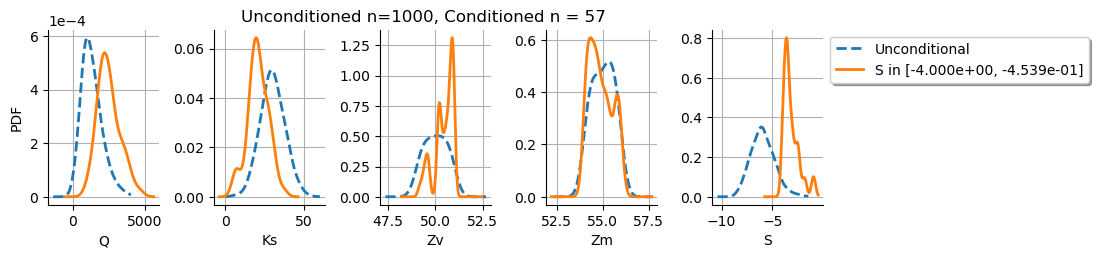

In [6]:
outputIndex = 1  # We consider the output S
lowerBound = -4.0  # We want to avoid flooding, i.e. S > -4
outputSampleMax = outputSample.getMax()
upperBound = outputSampleMax[outputIndex]  # We do not consider an active upper bound
print(f"Lower bound = {lowerBound}")
print(f"Upper bound = {upperBound}")
grid = ots.plotConditionOutputBounds(
    inputSample,
    outputSample,
    outputIndex,
    lowerBound,
    upperBound,
    inputDistribution,
)
view = otv.View(
    grid,
    figure_kw={"figsize": (10.0, 2.5)},
    legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"},
)
plt.subplots_adjust(wspace=0.5, hspace=0.5, top=0.9, bottom=0.2)

The rightmost plot is the simplest to analyse. The unconditional distribution of $S$ (the dashed blue curve) is estimated using kernel smoothing. We see that most observations of $S$ are approximately in the interval $[-9,-3]$. The conditional distribution (the solid orange curve) corresponds to the distribution of $S | S \in [-4.0,-4.539]$. By design, this distribution is skewed on its left.

Observing the third plot with $Z_v$ on abscissa, we see that the event $S \in [-4,-4.54]$ is very sensitive to the variable $Z_v$, since its distribution is very spiky and unsymmetric compared to its unconditional distribution. This implies that the variable $Z_v$ is influential: when $Z_v$ is large, then the event $S \in [-4.0,-4.539]$ occurs more often.

## Using a quantile level

In the previous section, we have condition the output given an interval which was defined using _prior_ knowledge of the distribution of the output. Since this information is not always known, it might be convenient to compute the bounds using a method that does not require any knowledge of the bounds. One way to compute the bounds is to set a quantile level, say 0.9 for example. In this case, we are interested by the event $S \geq S_{0.9}$ where $S_{0.9}$ is the quantile of $S$ of level 0.9:
$$
\mathbb{P}(S > S_{0.9}) = 0.9.
$$
The exact value of $S_{0.9}$ is unknown because this require a knowledge of the distribution of the output of the physical model. Hence, we estimate $S_{0.9}$ by its sample estimator, which leads to $\hat{S}_{0.9}$. By selecting different values of the quantile level, we can see how influential each input variable is depending on the tail of the output that we consider.

Therefore, we compute the output bounds depending on a quantile of the output. We condition on the inputs which lead to the output being larger than its 50%, 70% and 90% quantile.

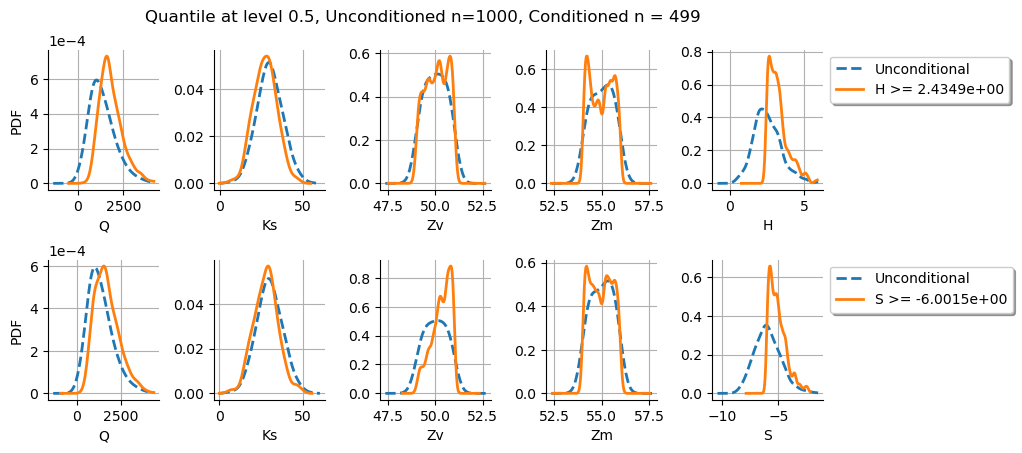

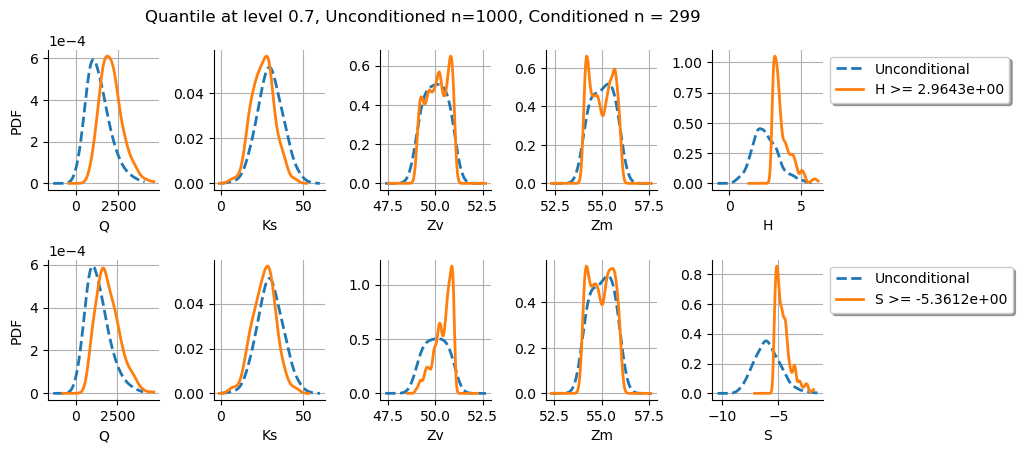

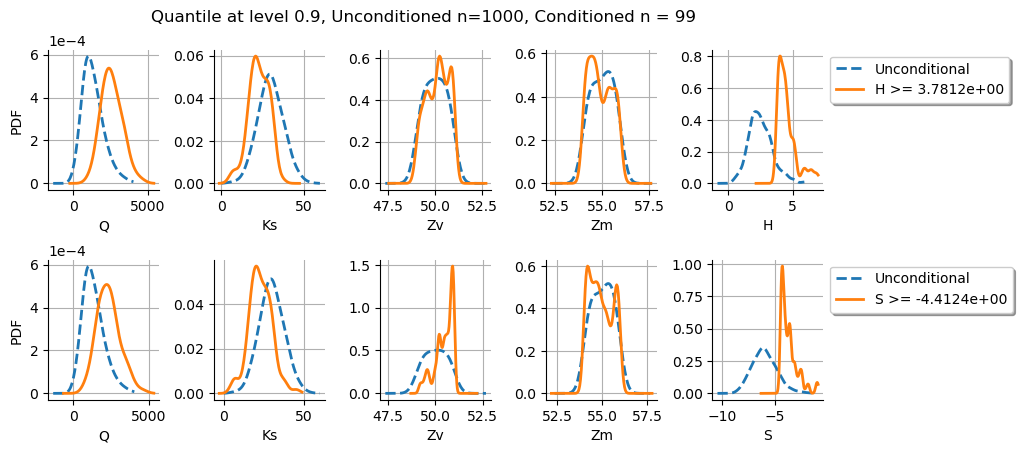

In [7]:
verbose = False
for quantile_level in [0.5, 0.7, 0.9]:
    grid = ots.plotConditionOutputQuantile(
        inputSample, outputSample, quantile_level, inputDistribution
    )
    view = otv.View(
        grid,
        figure_kw={"figsize": (10.0, 5.0)},
        legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"},
    )
    plt.subplots_adjust(wspace=0.5, hspace=0.5, top=0.9, bottom=0.2)

The analysis of the plot can be done by considering each plot individually. For example, consider the plot for the quantile level equal to 0.9. 
- The top right plot presents the unconditional distribution of the output, estimated by kernel smoothing. We see that most output values are approximately in the (1,2) interval. The quantile at level 0.9 is equal to 2.4. Therefore, we are interested by the event $H \geq 2.4$. The conditional distribution of the output $H | H \geq 2.4$ is slanted to the right.
- The top left plot presents the unconditional distribution of the input $Q$ and the conditional distribution of $Q| H \geq 2.4$. We see that there is a significant difference between these two disributions: when $H \geq 2.4$, then $Q$ is larger. 
- The second plot of the top line considers $K_s$. We see that, conditionaly on $H \geq 2.4$, lower values of $K_s$ appear. 
- The third plot of the top line considers $Z_v$: there is not much difference between the conditional and unconditional distributions. This shows that $Z_v$ is not very influential on the event $H \geq 2.4$. When we compare to the second row, we see that $Z_v$ has a large influence on the event that $S \geq -4.41$.  

The conclusion of the analysis is the following.
- For the output $H$, the most sensitive input variables are $Q$ and $K_s$: when $Q$ is large or $K_s$ is small, then the output can be large. The inputs $Z_v$ and $Z_m$ are not influential on this output. The influence of $K_s$ is stronger for relatively high values of the quantile of the output $H$. 
- For the output $S$, the most sensitive input variables are $Z_v$, $Q$ and $K_s$, but $Z_v$ is significantly more influential that the other ones. The variable $Z_m$ is not influential on this output.

One limitation of this method is that, when we consider values of the quantile level closer to 1, the conditional sub-sample is smaller. Hence, the kernel smoothing method may not have enough observations to perform an accurate estimation of the probability density function. For example, starting from a sample with size equal to $n = 1000$, the quantile level 0.1 lead to a conditional sub-sample size equal to 100. 

In [ ]:
outputIndex = 0
grid = ots.plotConditionOutputAll(inputSample, outputSample, outputIndex)
view = otv.View(
    grid,
    figure_kw={"figsize": (10.0, 5.0)},
    legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"},
)
plt.subplots_adjust(wspace=0.5, hspace=0.5, top=0.9, bottom=0.2)